# Collaboration Network Creation + Statistics

This notebook generates our collaboration network of researchers from paper collaborations, then calculates degree and betweenness centrality measures of this network.  It also generates plots to help understand the centralities.

## Imports

In [69]:
import pandas as pd
import os
import json
from tqdm.auto import tqdm
import networkx as nx
import semanticscholar as sch
import urllib
import json
import requests
import glob
import itertools
import numpy as np
from pandarallel import pandarallel
from fuzzywuzzy import fuzz, process
import string
import pickle
from matplotlib import pyplot as plt
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Extract paper attributes from conference json files and create dataframe of authors

In [55]:
authors = []
edges = []
counter = 0
for filepath in tqdm(glob.glob("../data/citation-networks-idea-propogation/data/mag_papers/*")):
    if 'NIPS' in filepath:
        continue
    papers = json.load(open(filepath, 'r'))
    for p in papers['entities']:
        if 'ICLR' in filepath and p['Y'] == 2018:
            counter += 1
        if 'RId' not in p:
            p_influenced_by = []
        else:
            p_influenced_by = p['RId']
        p_id = p['Id']
        p_title = p['Ti']
        p_date = p['D']

        p_authors = p['AA']
        if len(p_authors) > 1:
            authors.extend(p_authors)
        edges.extend(itertools.combinations(p_authors, 2))

In [56]:
# View author dataframe
author_df = pd.DataFrame(authors).drop('S', axis=1).drop_duplicates()
author_df

,AuN,AuId,AfId,AfN
0,rico sennrich,93200637,NaN,NaN
1,barry haddow,2179150568,NaN,NaN
2,alexandra birch,2099661360,NaN,NaN
3,jeremy howard,2783035492,NaN,NaN
4,sebastian ruder,2140581490,188760350.0,national university of ireland galway
...,...,...,...,...
155990,peng li,2694756589,NaN,NaN
155991,heng huang,2630638459,NaN,NaN
155992,xin tang,2474952701,NaN,NaN
155993,fei li,3043673082,NaN,NaN


## Clean Author Dataframe
* Remove duplicates
* Fix null values
* Fix data types

In [101]:
author_df.columns = [x.lower() for x in author_df.columns]
author_df.loc[author_df.afid.isnull(), 'afid'] = -1
author_df.loc[author_df.afn.isnull(), 'afn'] = "unaffiliated"
author_df.afid = author_df.afid.astype(int)
author_df = author_df.drop_duplicates()

## Create edge list and graph

In [59]:
pure_edges = list(set([(s['AuId'], t['AuId']) for s, t in edges]))
print("Number of edges:", len(pure_edges)) 
# pickle.dump(pure_edges, open('../data/edges/edge_list.pkl', 'wb'))

In [61]:
g = nx.Graph()
g.add_edges_from(pure_edges)

## Merge prestige data

In [102]:
prestige_data = pd.read_pickle("../data/prestige/prestige_data.pkl").dropna()
author_df = author_df[author_df['afn'].map(lambda x: x in set(prestige_data['affiliation'].values))]
prestige_data

,id,affiliation,pi,csrankings,usnews,prestige
8,57206974,new york university,0.111467,0.177670,0.736842,0.543095
10,161318765,university of california los angeles,0.114316,0.320388,0.763158,0.592671
12,97018004,stanford university,1.000000,0.502913,1.000000,0.889536
15,20089843,princeton university,0.229858,0.112621,0.842105,0.611970
17,63966007,massachusetts institute of technology,0.628989,0.412621,1.000000,0.828248
...,...,...,...,...,...,...
2151,89466785,minia university,0.006965,0.073786,0.210526,0.157522
2223,307268238,kaduna state university,0.008281,0.006796,0.236842,0.160325
2244,186803428,brock university,0.090620,0.133010,0.684211,0.495767
2290,161057412,university of new hampshire,0.002009,0.018447,0.105263,0.074498


In [79]:
# Add prestige and school ranking to author dataframe
prestige_data['rank'] = prestige_data['prestige'].rank(ascending=False, method='first')
rank_map = {afid:rank for (afid, rank) in prestige_data[['id','rank']].values}
prestige_map = {afid:prestige for (afid, prestige) in prestige_data[['id','prestige']].values}
author_df['prestige'] = author_df['afid'].map(prestige_map)
author_df['prestige_rank'] = author_df['afid'].map(rank_map)
author_df

,id,affiliation,pi,csrankings,usnews,prestige,rank
8,57206974,new york university,0.111467,0.177670,0.736842,0.543095,20.0
10,161318765,university of california los angeles,0.114316,0.320388,0.763158,0.592671,16.0
12,97018004,stanford university,1.000000,0.502913,1.000000,0.889536,1.0
15,20089843,princeton university,0.229858,0.112621,0.842105,0.611970,14.0
17,63966007,massachusetts institute of technology,0.628989,0.412621,1.000000,0.828248,3.0
...,...,...,...,...,...,...,...
2151,89466785,minia university,0.006965,0.073786,0.210526,0.157522,124.0
2223,307268238,kaduna state university,0.008281,0.006796,0.236842,0.160325,111.0
2244,186803428,brock university,0.090620,0.133010,0.684211,0.495767,30.0
2290,161057412,university of new hampshire,0.002009,0.018447,0.105263,0.074498,156.0


,aun,auid,afid,afn,degree,closeness,prestige,prestige_rank
5,abigail see,2778789062,97018004,stanford university,5,0.143639,0.889536,1.0
7,christopher d manning,2149153931,97018004,stanford university,50,0.163866,0.889536,1.0
12,waleed ammar,2016553074,74973139,carnegie mellon university,38,0.152146,0.826825,4.0
13,chandra bhagavatula,2071644166,111979921,northwestern university,43,0.151919,0.396567,44.0
15,xuezhe ma,2250429641,74973139,carnegie mellon university,41,0.163796,0.826825,4.0
...,...,...,...,...,...,...,...,...
155147,john male,2603478243,84392919,temple university,3,0.092708,0.100680,139.0
155184,bharti goel,2773401911,2613432,university of south florida,1,0.000015,0.160271,112.0
155413,laura dietz,2343535024,161057412,university of new hampshire,1,0.000015,0.074498,156.0
155600,rashidul islam,2901284325,79272384,university of maryland baltimore county,1,0.000015,0.114173,131.0


## Add degree and closeness centrality measures

In [103]:
degree_map = dict(g.degree())
author_df['degree'] = author_df.auid.map(degree_map)

In [64]:
author_df['closeness'] = author_df['auid'].parallel_map(lambda v: nx.centrality.closeness_centrality(g, v))
author_df.to_pickle('../data/nodes/author_centrality_final.pkl')

## View centralities

In [65]:
median_degrees = author_df.groupby('afn').degree.median()
median_degrees.sort_values().tail(50)

afn
university of texas at arlington          5.0
washington state university               5.0
yazd university                           5.0
rensselaer polytechnic institute          5.5
university of notre dame                  5.5
washington university in st louis         5.5
kent state university                     5.5
university of wisconsin madison           6.0
virginia tech                             6.0
xidian university                         6.0
university of oregon                      6.0
university of pennsylvania                6.0
university of rochester                   6.0
princeton university                      6.0
moscow state university                   6.0
california institute of technology        6.0
brock university                          6.0
cornell university                        6.0
duke university                           6.0
florida international university          6.0
massachusetts institute of technology     6.0
brandeis university           

In [53]:
closeness = author_df.groupby('afn')['closeness'].median()
closeness.sort_values().tail(50)

afn
university of oregon                     0.123561
eastern michigan university              0.123608
california institute of technology       0.124006
university of south carolina             0.124407
portland state university                0.124581
university of illinois at chicago        0.125178
indiana university                       0.125948
harvard university                       0.125952
university of pittsburgh                 0.125983
university of central florida            0.126200
washington university in st louis        0.126675
vanderbilt university                    0.127037
washington state university              0.127086
northwest university                     0.127242
northwestern university                  0.127244
duke university                          0.127329
columbia university                      0.127455
bocconi university                       0.127530
university of pennsylvania               0.127989
university of michigan                   0.128

## Make centrality plots

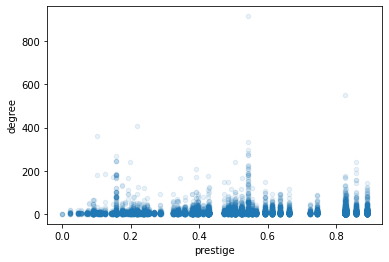

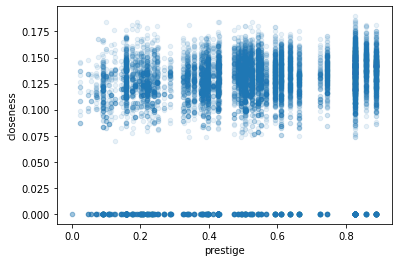

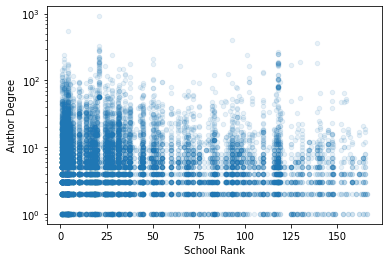

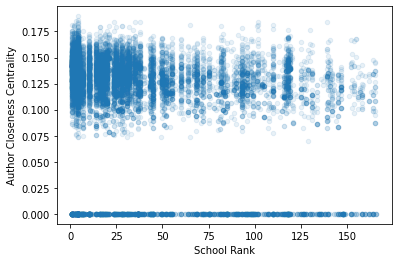

In [100]:
author_df.plot.scatter('prestige','degree', alpha=.1)
plt.show()

author_df.plot.scatter('prestige','closeness', alpha=.1)
plt.show()

author_df.plot.scatter('prestige_rank','degree', alpha=.1)
plt.yscale('log')
plt.xlabel("School Rank")
plt.ylabel("Author Degree")
plt.savefig("../figures/deg_vs_prestige.png")
plt.show()

author_df.plot.scatter('prestige_rank','closeness', alpha=.1)
plt.xlabel("School Rank")
plt.ylabel("Author Closeness Centrality")
plt.savefig('../figures/deg_vs_closeness.png')
plt.show()

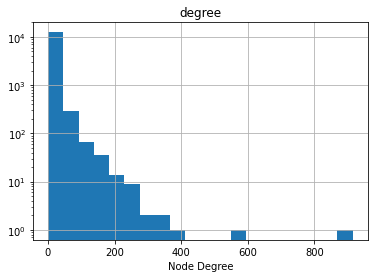

In [89]:
author_df.hist('degree', bins=20)
plt.xlabel("Node Degree")
plt.yscale('log')

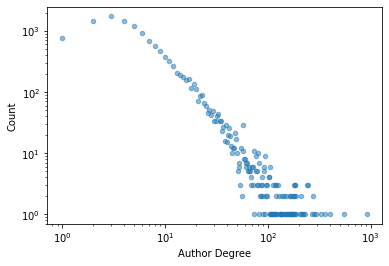

In [99]:
author_df.groupby('degree').count().reset_index().plot.scatter('degree','prestige_rank', alpha=.5)
plt.yscale('log')
plt.xscale('log')
# plt.title("Collaboration Network Degree Distribution")
plt.xlabel('Author Degree')
plt.ylabel('Count')
plt.savefig("../figures/degree_dist.png")
plt.show()

In [17]:
glob.glob("/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/*")

['/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/dataMAG_ACL.json',
 '/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/dataMAG_ICLR.json',
 '/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/dataMAG_AAAI.json',
 '/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/dataMAG_COLING.json',
 '/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/dataMAG_CVPR.json',
 '/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/dataMAG_ICCV.json',
 '/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/dataMAG_EMNLP.json',
 '/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/dataMAG_ICML.json',
 '/nethome/dkartchner3/school/epi/citation-networks-idea-propogation/data/mag_papers/dataMAG_KDD.json',
 '/nethome/dkartchner3/school/epi/citation-networks-id

In [34]:
pd.read_pickle('../data/nodes/author_centrality.pkl')

,auid,aun,closeness
0,0,hadrian paulo m lim,0.000091
1,1,maria regina justina e estuar,0.000091
2,2,john clifford rosales,0.000091
3,3,ma regina e estuar,0.000091
4,4,luke prudente,0.000091
...,...,...,...
64172,54670,thomas ricatte,0.176260
64173,54671,r anton,0.000018
64174,54672,k dmitry,0.000018
64175,54673,tianqi chen,0.000018


In [37]:
author_df = pd.read_pickle("../data/nodes/author_list.pkl")

In [38]:
author_df

,AuN,AuId,AfN,AfId
0,hadrian paulo m lim,2750994513,ateneo de manila university,19722.0
1,maria regina justina e estuar,2033405482,ateneo de manila university,19722.0
2,john clifford rosales,2575604137,ateneo de manila university,19722.0
3,ma regina e estuar,1462213806,ateneo de manila university,19722.0
4,luke prudente,2610175157,ateneo de manila university,19722.0
...,...,...,...,...
64172,thomas ricatte,256014509,NaN,NaN
64173,r anton,2271936098,NaN,NaN
64174,k dmitry,2516428222,NaN,NaN
64175,tianqi chen,2670372115,NaN,NaN
